```{admonition} Lecture Materials
:class: tip
[Download the slide deck for this lecture](https://github.com/vlvovch/PHYS6350-ComputationalPhysics/blob/spring2025/slides/Lecture19-04-03-25-StatisticalPhysics.pdf)
```

# Ising model

Ising model represents a system of spins (magnetic dipoles) on a lattice.
Without external magnetic field, the energy reads

$$
E = -J \sum_{<ij>} s_i s_j,
$$

where $J > 0$ for a ferromagnetic.
For nearest-neighbor interaction only, the sum runs over the pairs of neighboring lattice sites.

```{figure} img/2DIsing.png
    :name: fig:2DIsing
    :width: 300px
    :align: center
```
<center>
    Source: https://ruihaoqiu.github.io/MC-Magnetic-Phase-Transition/
</center>

Here each dipole interacts with its four neighbors (or two/three neighbors in case of the spins at the edges).
The magnetization is given by

$$
M = \sum_{i} s_i.
$$

It is know that below the Curie temperature

$$
\frac{k_B T_C}{J} = \frac{2}{\ln(1+\sqrt{2})} \approx 2.27,
$$

the system attains a spontaneous magnetization $|M| > 0$.
We can simulate this process using Markov chain and the Metropolis algorithm.

Let us apply the Metropolis algorithm to simulate the system.
Each state is given by the spin configutation $\{ s_i \}$.
At each step we randomly choose one spin $i$ and flip its orientation $s_i$ to $-s_i$.
Such a flip would case the energy of the system to change by

$$
\Delta E = 2 J \sum_{j} s_i s_j.
$$

The new state is then accepted with a probability

$$
P_a = e^{-\Delta E / T}.
$$

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Energy of 2D Ising system for a given spin configuration
def IsingE(spins, periodicBC = False):
    energy = 0
    N = len(spins)
    for i in range(N):
        for j in range(N):
            if (i > 0 or periodicBC):
                energy += -spins[i][j] * spins[i-1][j]
            if (j > 0 or periodicBC):
                energy += -spins[i][j] * spins[i][j-1]
            if (i < N - 1 or periodicBC):
                energy += -spins[i][j] * spins[(i+1)%N][j]
            if (j < N - 1 or periodicBC):
                energy += -spins[i][j] * spins[i][(j+1)%N]
    return energy

# Magnetization of 2D Ising system for a given spin configuration
def IsingM(spins):
    return np.sum(spins)

# Change of energy of the Ising system by flipping the spin at the location (i,j)
def IsingdEflip(spins, i, j, periodicBC = False):
    N = len(spins)
    dE = 0
    if (i > 0 or periodicBC):
        dE += 2 * spins[i][j] * spins[i-1][j]
    if (j > 0 or periodicBC):
        dE += 2 * spins[i][j] * spins[i][j-1]
    if (i < N - 1 or periodicBC):
        dE += 2 * spins[i][j] * spins[(i+1)%N][j]
    if (j < N - 1 or periodicBC):
        dE += 2 * spins[i][j] * spins[i][(j+1)%N]
    return dE

from IPython.display import clear_output
from matplotlib.colors import ListedColormap

# Whether to plot the configuration
plotSimulation = False

# Simulates the 2D Ising system of NxN spins at temperature T
# by performing Markov chain steps using Metropolis algorithm
# Returns arrays energies and magnetizations at each step
def simulateIsing(T, N, steps, periodicBC = False):
    spins = -1 + 2 * np.random.randint(0, high = 2, size=(N,N))
    
    E = IsingE(spins, periodicBC)
    M = IsingM(spins)

    # Energy
    eplot = [ E ]
    # Magnetisation
    Mplot = [ M ]

    for k in range(steps):
        # Pick the lattice site randomly
        i = np.random.randint(N)
        j = np.random.randint(N)
        
        # Energy change from flipping the site
        dE = IsingdEflip(spins, i, j, periodicBC)
        
        # Flip the spin with some probability
        if (np.random.rand() < np.exp(-dE/T)):
            spins[i,j] = -spins[i,j]
            E += dE
            M += 2 * spins[i,j]
        
        eplot.append(E)
        Mplot.append(M)

        # plot the system
        if plotSimulation:
            toPlot = False

            # Plot each sweep
            if (k%(N**2) == 0):
                toPlot = True
            
            if (toPlot):
                clear_output(wait=True)
                # time.sleep(0.01)
                plt.title("2D Ising, ${N = }$" + '{0:d}'.format(N))
                plt.xlabel("x")
                plt.ylabel("y")
                cmap = ListedColormap(['w', 'black'])
                CS = plt.imshow(spins.T, vmax=1, vmin=-1,origin="lower",extent=[0,N,0,N], cmap=cmap,  interpolation='nearest')
                # plt.colorbar(CS)
                plt.show()
        
    
    return eplot, Mplot

Let us simulate the system at $T = 1 < T_C$ several times and keep track of the magnetization.

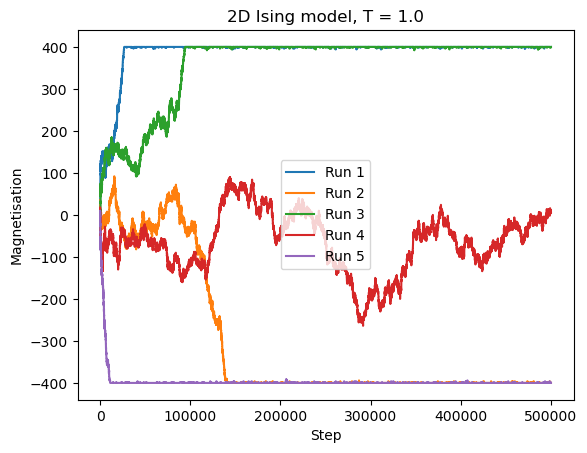

CPU times: user 14.7 s, sys: 444 ms, total: 15.1 s
Wall time: 15.1 s


In [ ]:
%%time

N = 20
steps = 500000
periodicBC = True
Temperature = 1. # Tc = 2. / np.log(1+np.sqrt(2.)) \approx 2.27
Ts = np.empty(5)
Ts.fill(Temperature)
eplots = []
Mplots = []

plotSimulation = False

for T in Ts:
    resE, resM = simulateIsing(T, N, steps, periodicBC)
    eplots.append(resE)
    Mplots.append(resM)

# Make the graph
import matplotlib.pyplot as plt

for i in range(len(Ts)):
    leg = "Run " + str(i + 1)
    plt.plot(Mplots[i],label=leg)

plt.title("2D Ising model, T = " + str(Temperature))
plt.xlabel("Step")
plt.ylabel("Magnetisation")
plt.legend()
plt.show()

We observe that the magnetization spontaneoulsy attains either positive or negative values.

Let us now consider different temperatures

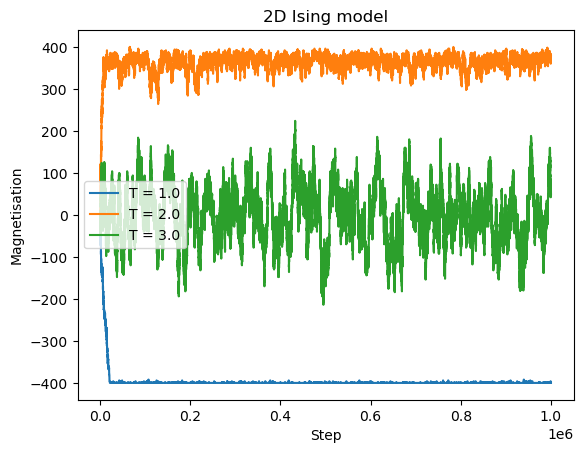

CPU times: user 19.9 s, sys: 404 ms, total: 20.3 s
Wall time: 20.1 s


In [6]:
%%time

N = 20
steps = 1000000
periodicBC = True
Ts = [1., 2., 3.]
eplots = []
Mplots = []

plotSimulation = False

for T in Ts:
    resE, resM = simulateIsing(T, N, steps, periodicBC)
    eplots.append(resE)
    Mplots.append(resM)

# Make the graph
import matplotlib.pyplot as plt

for i in range(len(Ts)):
    leg = "T = " + str(Ts[i])
    plt.plot(Mplots[i],label=leg)

plt.title("2D Ising model")
plt.xlabel("Step")
plt.ylabel("Magnetisation")
plt.legend()
plt.show()

The system reaches non-zero magnetization below the Curie temperature $T_C \approx 2.27$, and the process is faster at lower temperatures.
For $T = 3 > T_C$, the magnetization fluctuates around zero.